In [168]:
# Let's load values from the .env file
from dotenv import dotenv_values

config = dotenv_values()

# We also will need SQLAlchemy and its functions
from sqlalchemy import create_engine, types
from sqlalchemy.dialects.postgresql import JSON as postgres_json
from sqlalchemy import text # to be able to pass string

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# this so called "line magic" command, amongst other things, stores the plots in the notebook document.
%matplotlib inline

# warnings supression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import the statsmodels.api module
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [169]:
# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

#SQL access details
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'
engine = create_engine(url, echo=False)
engine.url # password is hidden
with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {pg_schema};'))

In [170]:
with engine.begin() as conn: # Done with echo=False
    result = conn.execute(text(f'''
                               SELECT * FROM mart_song; 
                                '''))
    data = result.all()

### Let's create a dataframe out of that
df_song = pd.DataFrame(data) 

In [171]:
filter = ((df_song['beats_per_min'].notnull()) & (df_song['energy'].notnull()) & (df_song['danceability'].notnull()) & 
          (df_song['happiness'].notnull()) & (df_song['acousticness'].notnull()) & (df_song['instrumentalness'].notnull()) 
          & (df_song['liveness'].notnull()) & (df_song['speechiness'].notnull()) & (df_song['final_total_points'].notnull()))
df_song_filter = df_song[filter]

In [172]:
df_song_model['final_total_points'].isnull().sum()

np.int64(0)

In [173]:
#convert "team" to dummy variable
df_song_model = pd.get_dummies(df_song_filter, columns=['key', 'style'], drop_first=True, dtype='int')

In [175]:
# Choose the independent variable, the predictor X  

X = df_song_model[['beats_per_min','energy', 'danceability', 'happiness', 
        'acousticness', 'instrumentalness', 'liveness', 'speechiness', 
        'key_A Minor', 'key_Ab Major', 'key_Ab Minor', 'key_B Major', 
        'key_B Minor', 'key_Bb Major', 'key_Bb Minor', 'key_C Minor',
       'key_Cs Minor', 'key_D Major', 'key_D Minor', 'key_Db Major',
       'key_Db Minor', 'key_E Major', 'key_E Minor', 'key_Eb Major',
       'key_Eb Minor', 'key_F Major', 'key_F Minor', 'key_Fs Major',
       'key_Fs Minor', 'key_G Major', 'key_G Minor', 'style_Dance',
       'style_Opera', 'style_Pop', 'style_Rock', 'style_Traditional']]

# X = df_song_model[['main_singers', 'beats_per_min', 'energy',
#        'danceability', 'happiness', 'acousticness', 'instrumentalness',
#        'liveness', 'speechiness', 'backing_dancers', 'backing_singers',
#        'backing_instruments', 'point_ratio', 'betting_odds', 'gender_Male',
#        'gender_Mix', 'key_A Minor', 'key_Ab Major', 'key_Ab Minor',
#        'key_B Major', 'key_B Minor', 'key_Bb Major', 'key_Bb Minor',
#        'key_C Major', 'key_C Minor', 'key_Cs Major', 'key_Cs Minor',
#        'key_D Major', 'key_D Minor', 'key_Db Major', 'key_Db Minor',
#        'key_E Major', 'key_E Minor', 'key_Eb Major', 'key_Eb Minor',
#        'key_F Major', 'key_F Minor', 'key_Fs Major', 'key_Fs Minor',
#        'key_G Major', 'key_G Minor', 'style_Dance', 'style_Opera', 'style_Pop',
#        'style_Rock', 'style_Traditional', 'loudness_db_11', 'loudness_db_12',
#        'loudness_db_13', 'loudness_db_2', 'loudness_db_3', 'loudness_db_4',
#        'loudness_db_5', 'loudness_db_6', 'loudness_db_7', 'loudness_db_8',
#        'loudness_db_9']]

# 'style', 'gender', 'key' removed

# Define dependent variable (since it's always a single variable, we can use dot notation here)
y = df_song_model[['final_total_points']]


In [176]:
# dividing the dataset into two subsets 
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3, random_state=42) #splittin the data into train and test dataset, 30% test 70% train

# Since our statsmodel OLS model needs an adjustable intercept, we add a column of 1s to:
Xtrain = sm.add_constant(Xtrain)
display(Xtrain.head())

,const,beats_per_min,energy,danceability,happiness,acousticness,instrumentalness,liveness,speechiness,key_A Minor,...,key_F Minor,key_Fs Major,key_Fs Minor,key_G Major,key_G Minor,style_Dance,style_Opera,style_Pop,style_Rock,style_Traditional
75,1.0,95.0,76.0,39.0,41.0,0.0,79.0,12.0,3.0,0,...,0,0,0,0,0,0,0,0,1,0
106,1.0,120.0,85.0,73.0,12.0,16.0,1.0,10.0,5.0,1,...,0,0,0,0,0,0,0,1,0,0
169,1.0,140.0,67.0,55.0,54.0,21.0,0.0,12.0,4.0,0,...,0,0,1,0,0,0,0,1,0,0
49,1.0,110.0,42.0,55.0,23.0,70.0,0.0,14.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0
136,1.0,83.0,50.0,52.0,25.0,31.0,0.0,10.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
# create an OLS model
song_model = sm.OLS(ytrain, Xtrain)

# use the data to calculate the intercept and slope
model_results = song_model.fit()

# return the output of the model
model_results.summary() # summary contains eg. 'const' (intercept) and 'slope' of the regression equation.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     final_total_points   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.9785
Date:                Wed, 02 Apr 2025   Prob (F-statistic):              0.520
Time:                        14:47:00   Log-Likelihood:                -551.38
No. Observations:                  88   AIC:                             1175.
Df Residuals:                      52   BIC:                             1264.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                53.4513    195.619      0.273      0.786    -339.086     445.989
beats_per_min        -0.4585      0.986     -0.465      0.644      -2.436       1.519
energy                1.7978      2.158      0.833      0.409      -2.532       6.127
danceability         -2.3852      1.941     -1.229      0.225      -6.280       1.509
happiness            -0.4187      1.331     -0.315      0.754      -3.090       2.252
acousticness          3.5775      1.608      2.225      0.030       0.351       6.804
instrumentalness      0.7882      1.976      0.399      0.692      -3.176       4.753
liveness              0.6621      2.139      0.310      0.758      -3.629       4.954
speechiness          -0.4723      7.071     -0.067      0.947     -14.661      13.716
key_A Minor          43.0858    106.869      0.403      0.688    -171.362     257.533
key_Ab Major        -32.8135    101.654     -0.323      0.748    -236.797     171.170
key_Ab Minor         90.3843    119.510      0.756      0.453    -149.431     330.199
key_B Major         109.5675    192.166      0.570      0.571    -276.041     495.176
key_B Minor         204.8877    123.452      1.660      0.103     -42.837     452.612
key_Bb Major        154.2774    118.269      1.304      0.198     -83.046     391.601
key_Bb Minor        -47.8854     99.126     -0.483      0.631    -246.796     151.025
key_C Minor          42.9103    116.207      0.369      0.713    -190.276     276.097
key_Cs Minor        151.7346    142.919      1.062      0.293    -135.053     438.522
key_D Major         329.1265    112.073      2.937      0.005     104.236     554.017
key_D Minor          10.3957    113.803      0.091      0.928    -217.966     238.757
key_Db Major         14.4131    105.098      0.137      0.891    -196.481     225.308
key_Db Minor         26.0582    188.126      0.139      0.890    -351.444     403.560
key_E Major        -140.0420    169.502     -0.826      0.412    -480.173     200.089
key_E Minor          15.6104    102.999      0.152      0.880    -191.073     222.293
key_Eb Major         54.4568    150.421      0.362      0.719    -247.384     356.298
key_Eb Minor        230.7502    136.068      1.696      0.096     -42.290     503.790
key_F Major          -5.4378    143.903     -0.038      0.970    -294.200     283.324
key_F Minor         -33.0287    109.817     -0.301      0.765    -253.394     187.336
key_Fs Major        394.8227    185.598      2.127      0.038      22.392     767.253
key_Fs Minor        -35.9187    105.672     -0.340      0.735    -247.964     176.127
key_G Major         -31.6648    109.388     -0.289      0.773    -251.168     187.838
key_G Minor          29.9207    119.338      0.251      0.803    -209.548     269.390
style_Dance         336.7686    153.406      2.195      0.033      28.938

In [178]:
# Add a constant to the test data for the intercept
Xtest = sm.add_constant(Xtest)

# Make predictions using the test data
y_pred = model_results.predict(Xtest)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(ytest, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared (R^2)
r2 = r2_score(ytest, y_pred)
print(f"R-squared (R^2): {r2}")

Mean Squared Error (MSE): 49773.46034841531
Root Mean Squared Error (RMSE): 223.09966460847787
R-squared (R^2): -1.5923270704628747


In [179]:
# adding test values and predicted values + calculating squared error for each record
y_pred.name = 'final_total_points_pred' # assigning a name to the y_pred Series, to get a column name below
df_eval = pd.concat([Xtest, ytest, y_pred], axis=1)
df_eval['squared_error'] = (df_eval['final_total_points'] - df_eval['final_total_points_pred'])**2
df_eval

,const,beats_per_min,energy,danceability,happiness,acousticness,instrumentalness,liveness,speechiness,key_A Minor,...,key_G Major,key_G Minor,style_Dance,style_Opera,style_Pop,style_Rock,style_Traditional,final_total_points,final_total_points_pred,squared_error
45,1.0,95.0,59.0,73.0,35.0,4.0,0.0,31.0,5.0,0,...,0,0,0,0,1,0,0,472.0,328.261910,20660.638505
177,1.0,79.0,63.0,33.0,55.0,26.0,0.0,27.0,5.0,0,...,0,0,0,0,1,0,0,173.0,480.019901,94261.219563
134,1.0,102.0,70.0,89.0,65.0,20.0,0.0,7.0,19.0,0,...,0,0,0,0,0,0,1,204.0,-6.936596,44494.247623
93,1.0,93.0,56.0,68.0,50.0,9.0,0.0,31.0,3.0,0,...,0,0,0,0,0,0,0,128.0,-20.338152,22004.207448
71,1.0,124.0,79.0,60.0,62.0,5.0,0.0,6.0,3.0,0,...,0,0,0,0,1,0,0,153.0,332.731140,32303.282583
155,1.0,117.0,81.0,75.0,76.0,2.0,0.0,7.0,10.0,0,...,0,0,0,0,1,0,0,181.0,189.199465,67.231229
133,1.0,120.0,76.0,69.0,51.0,0.0,1.0,13.0,5.0,0,...,0,0,0,0,1,0,0,115.0,298.901047,33819.594953
196,1.0,93.0,18.0,52.0,25.0,69.0,0.0,9.0,3.0,0,...,1,0,0,0,0,0,0,170.0,128.392432,1731.189702
180,1.0,126.0,79.0,59.0,52.0,15.0,0.0,21.0,11.0,1,...,0,0,1,0,0,0,0,38.0,417.429556,143966.787611
103,1.0,102.0,90.0,57.0,31.0,0.0,0.0,12.0,8.0,0,...,0,0,0,0,0,1,0,36.0,211.852546,30924.117869


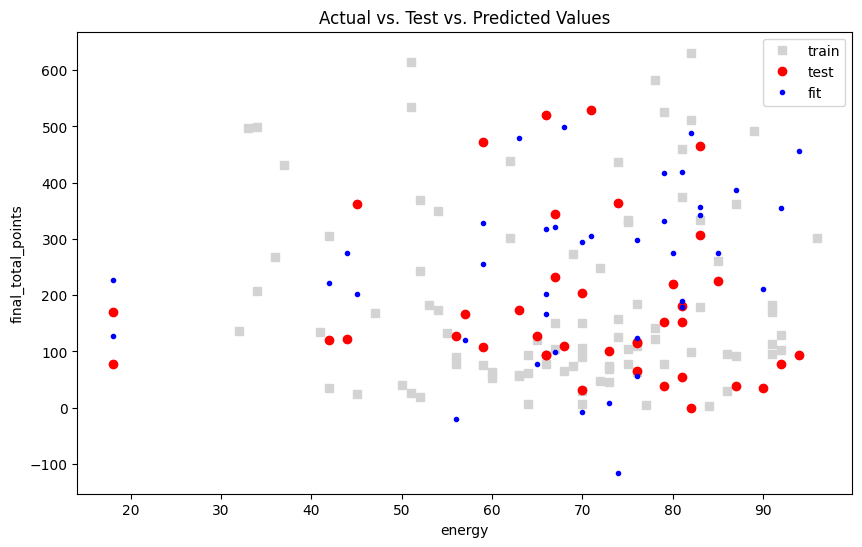

In [183]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(Xtrain['energy'], ytrain, 's', color='lightgray', label="train")
plt.plot(Xtest['energy'], ytest, 'ro', label="test")
plt.plot(Xtest['energy'], y_pred, 'bo', markersize=3, label="fit")

# # Add residuals (dashed lines)
# for i in range(len(Xtest)):
#     plt.plot([Xtest['energy'].iloc[i], Xtest['energy'].iloc[i]], 
#               [ytest.iloc[i], y_pred.iloc[i]], 
#               'k--', linewidth=0.5)

# Add labels and title
plt.xlabel('energy')
plt.ylabel('final_total_points')
plt.title('Actual vs. Test vs. Predicted Values')
plt.legend();